In [2]:
# ssh carnd@ip -L 4567:localhost:4567

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc as misc
import cv2 as cv
%matplotlib inline

# Fix error with TF and Keras
# import tensorflow as tf
# tf.python.control_flow_ops = tf

In [4]:
# df = pd.read_csv('./data/driving_log.csv', 
#                  names=['centre_image', 'left_image', 'right_image', 'steering_angle', 'throttle', 'break', 'speed'])
df = pd.read_csv('./data/driving_log.csv')
print(df.shape)
df.head(2)

(8036, 7)


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.14829
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.87963


In [5]:
# D:\SDCND\beta-simulator-windows\recording\IMG\center_2017_02_14_22_05_18_509.jpg

# df = df.replace(to_replace="D:\\\\SDCND\\\\beta-simulator-windows", value='.', regex=True).replace(to_replace='\\\\', value='/', regex=True)
df = df.replace(to_replace="( )?IMG", value='./data/IMG', regex=True)
df.head(2)

,center,left,right,steering,throttle,brake,speed
0,./data/IMG/center_2016_12_01_13_30_48_287.jpg,./data/IMG/left_2016_12_01_13_30_48_287.jpg,./data/IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.14829
1,./data/IMG/center_2016_12_01_13_30_48_404.jpg,./data/IMG/left_2016_12_01_13_30_48_404.jpg,./data/IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.87963


./data/IMG/center_2016_12_01_13_31_14_295.jpg
(160, 320, 3)


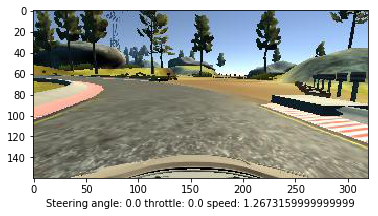

In [6]:
def show_image(index):
    print(df['center'][index])
    image = mpimg.imread(df['center'][index])
    print(image.shape)
    plt.imshow(image)
    plt.xlabel("Steering angle: {} throttle: {} speed: {}".format(df['steering'][index], df['throttle'][index], df['speed'][index]))

show_image(15)

plt.hist(df['steering'], bins=20)

# plt.hist(df['throttle'])

# df2 = df[(df['steering'] != 0)]
df_original = df
df2 = df[(df['steering'] <= -0.01) | (df['steering'] >= 0.01)].reset_index(drop=True)

print(df2.shape)
print(df2['steering'][100])
df = df2



plt.hist(df['steering'], bins=20)

# get images and labels

# camera = center, left, right
def get_images(df, camera='center'):
    result = []
    for path in df[camera]:
        img = mpimg.imread(path)
#         img = misc.imresize(img, (80,160))
        img = cv.resize(img, (80, 80), interpolation=cv.INTER_AREA)
        result.append(img)
    return np.stack(result)

x = get_images(df)
print(x.shape)

y = df.as_matrix(columns=['steering'])
print(y.shape)
print(y[10:15])
plt.hist(y, bins=20)

# use the left and right cameras
steering_adjustment = 0.20
x_left = get_images(df, camera='left')
y_left = y + steering_adjustment

x_right = get_images(df, camera='right')
y_right = y - steering_adjustment

print(x_left.shape)

x = np.append(x, x_left, axis=0)
y = np.append(y, y_left, axis=0)
x = np.append(x, x_right, axis=0)
y = np.append(y, y_right, axis=0)

# generate more data
# df_flip_data = df[(df['steering'] <= -0.1) | (df['steering'] >= 0.1)].reset_index(drop=True)
df_flip_data = df[(df['steering'] <= -0.01) | (df['steering'] >= 0.01)].reset_index(drop=True)
# df_flip_data = df[(df['steering'] <= -0.1)].reset_index(drop=True)
print(df_flip_data.shape)
x_flip = get_images(df_flip_data)
y_flip = df_flip_data.as_matrix(columns=['steering'])

y_flip = -y_flip
# print(x_flip.shape)
x_flip = [np.fliplr(a) for a in x_flip]
# plt.imshow(x_flip[100])

x = np.append(x, x_flip, axis=0)
y = np.append(y, y_flip, axis=0)
print(x.shape)
print(y.shape)


plt.figure(figsize=(20,10))
plt.hist(y, bins=40)

In [7]:
# TODO: Build a model
import keras
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Input
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.backend import tf as ktf

def traffic_sign_model():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    model.add(Convolution2D(32, 1, 1, border_mode='same'))
    model.add(Convolution2D(32, 3, 3, border_mode='same'))
    model.add(Convolution2D(32, 3, 3, border_mode='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2,2), border_mode='same'))
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2,2), border_mode='same'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile('adam', 'mse')
    return model

def VGG():
    # 3 channel images of arbitrary shape
#     inp = Input(shape=(None, None, 3))
#     out = Lambda(lambda image: keras.backend.tf.image.resize_images(image, (40, 80)))(inp)
    inp = Input(shape=(80, 80, 3))
    preproc = Lambda(lambda x: (x / 255.0) - 0.5)(inp)
#     preproc = Cropping2D(cropping=((50,20), (10,10)))(preproc)
#     preproc = Convolution2D(3, 1, 1, border_mode='same')(preproc)
    modelvgg = VGG16(include_top=False, weights=None, input_tensor=preproc, input_shape=None)
#     modelvgg = VGG16(include_top=False, weights=None, input_tensor=None, input_shape=(80,80,3))
#     model.summary()
    layer = Flatten(name='flatten')(modelvgg.layers[-1].output)
    layer = Dense(2048, activation='relu', name='dense1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(2048, activation='relu', name='dense2')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(128, activation='relu', name='dense3')(layer)
    layer = Dropout(0.5)(layer)
#     layer = Dense(32, activation='relu', name='dense4')(layer)
#     layer = Dropout(0.5)(layer)
    prediction = Dense(1)(layer)
    model = Model(modelvgg.input, prediction)
    adam = Adam(lr=0.00005)
    model.compile(adam, 'mse')
    return model

model = VGG()
model.summary()


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 80, 80, 3)     0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 80, 80, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 80, 80, 64)    1792        lambda_1[0][0]                   
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 80, 80, 64)    36928       block1_conv1[0][0]               
___________________________________________________________________________________________

history = model.fit(x, y, batch_size=128, nb_epoch=10, validation_split=0.2)

-0.382245149576


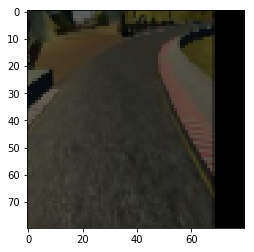

In [8]:
import random

def trans_image(image,steer,translation_range):
    # Translation
    x_translation = translation_range*np.random.uniform()-translation_range/2
    steer_ang = steer + x_translation/translation_range*2*.2
    y_translation = 40*np.random.uniform()-40/2

    translation_matrix = np.float32([[1,0,x_translation],[0,1,y_translation]])
    image_tr = cv.warpAffine(image,translation_matrix,(image.shape[1],image.shape[0]))
    
    return image_tr,steer_ang


def preprocess_img(row):
    img = None
    steering = None
    camera = ['left', 'center', 'right']
    steering_adjustment = [0.2, 0, -0.2]
    camera_selection = random.randint(0, 2)
    
    steering = row['steering'] + steering_adjustment[camera_selection]
        
    img = cv.imread(row[camera[camera_selection]])
    img, steering = trans_image(img,steering,100)
    
    img = img[50:130,0:320]
    img = cv.resize(img, (80, 80), interpolation=cv.INTER_AREA)
    
    # randomly adjust brightness 
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    brightness = 0.25 + np.random.uniform()
    img[:, :, 2] = img[:, :, 2] * brightness
    img = cv.cvtColor(img, cv.COLOR_HSV2RGB)
    
    #random flip
    flip = random.randint(0, 1)
    if flip == 1: 
        img = np.fliplr(img)
        steering = -steering
    
    return img, steering

img, steering = preprocess_img(df.iloc[5])
print(steering)
plt.imshow(img)


In [19]:
## instead of above, and just plain training, let's use a generator to help randomly augment data

# df_generator = df[(df['steering'] <= -0.01) | (df['steering'] >= 0.01)].reset_index(drop=True)
df_generator = df
print(len(df_generator))
import sklearn
import cv2 as cv
def generator(df, batch_size=256):
    num_samples = len(df)
    pr_threshold = 1
    while 1: # Loop forever so the generator never terminates
        x_sample = []
        y_sample = []
        
        for i in range(batch_size):
            index = np.random.randint(len(df))
            row = df.iloc[index]
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                image, steering = preprocess_img(row)
                pr_unif = np.random
                if abs(steering)<.1:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            x_sample.append(image)
            y_sample.append(steering)
        yield np.stack(x_sample), np.asarray(y_sample).reshape(batch_size, 1)
        pr_threshold = 0.90 * pr_threshold
        
train_generator = generator(df_generator)
validation_generator = generator(df_generator)

8036


(array([   2.,    2.,    6.,    8.,    7.,   17.,   30.,   41.,   85.,
         183.,  186.,  194.,  224.,  340.,  289.,  171.,  126.,  139.,
         147.,  278.,  349.,  255.,  205.,  155.,  167.,  101.,   42.,
          33.,   23.,   11.,    2.,   10.,    7.,    2.,    2.,    0.,
           0.,    0.,    0.,    1.]),
 array([-0.81480007, -0.76714234, -0.71948462, -0.6718269 , -0.62416918,
        -0.57651145, -0.52885373, -0.48119601, -0.43353828, -0.38588056,
        -0.33822284, -0.29056512, -0.24290739, -0.19524967, -0.14759195,
        -0.09993423, -0.0522765 , -0.00461878,  0.04303894,  0.09069667,
         0.13835439,  0.18601211,  0.23366983,  0.28132756,  0.32898528,
         0.376643  ,  0.42430072,  0.47195845,  0.51961617,  0.56727389,
         0.61493162,  0.66258934,  0.71024706,  0.75790478,  0.80556251,
         0.85322023,  0.90087795,  0.94853567,  0.9961934 ,  1.04385112,
         1.09150884]),
 <a list of 40 Patch objects>)

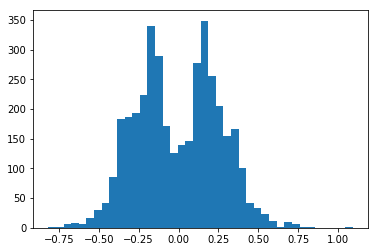

In [20]:
# testing distribution
test_y = [next(train_generator)[1] for i in range(15)]
test_y = np.vstack(test_y)

plt.hist(test_y , bins=40)
# this will shuffle a dataframe df.sample(frac=1).reset_index(drop=True)

In [21]:
history = model.fit_generator(train_generator, samples_per_epoch= 256*60, nb_epoch=10)

# history = model.fit_generator(train_generator, 
#                               samples_per_epoch= 256*15, 
#                               validation_data=validation_generator, 
#                               nb_val_samples=256*4, 
#                               nb_epoch=10)

Epoch 1/20
3840/3840 [==============================] - 43s - loss: 0.0565      

dict_keys(['loss'])


KeyError: 'val_loss'

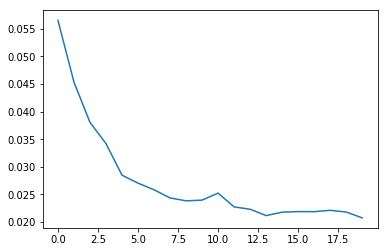

In [22]:
### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [23]:
model.save('./model.h5')


In [ ]:
# from keras.models import load_model
# model = load_model('./model.h5')

index: 170  actual:  [ 0.20689196]  prediction: [[ 0.25656912]]  diff: [[ 0.04967716]]
index: 181  actual:  [-0.27089053]  prediction: [[-0.27700931]]  diff: [[-0.00611878]]
index: 168  actual:  [ 0.12166651]  prediction: [[ 0.11710174]]  diff: [[-0.00456478]]
index: 105  actual:  [ 0.18862581]  prediction: [[ 0.23528619]]  diff: [[ 0.04666038]]
index: 102  actual:  [ 0.13898318]  prediction: [[ 0.19770835]]  diff: [[ 0.05872518]]
index: 24  actual:  [ 0.12263273]  prediction: [[ 0.03234637]]  diff: [[-0.09028636]]
index: 176  actual:  [-0.12394677]  prediction: [[-0.18495955]]  diff: [[-0.06101278]]
index: 190  actual:  [-0.18937044]  prediction: [[-0.16222905]]  diff: [[ 0.0271414]]
index: 32  actual:  [ 0.11005436]  prediction: [[ 0.00130704]]  diff: [[-0.10874732]]


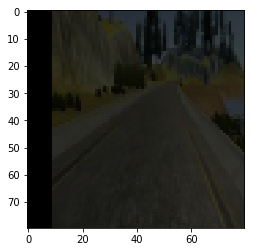

In [29]:
import random

x, y = next(generator(df_generator))

for i in range(1, 10):
    test_index=random.randint(0, len(x))
#     print(test_index)
    test_image = x[test_index]
#     print(y[test_index])
    prediction = model.predict(test_image[None, :, :, :], batch_size=1)
    print("index:", test_index, " actual: ", y[test_index], " prediction:", prediction, " diff:", prediction - y[test_index])


plt.imshow(test_image)

In [ ]:
# from IPython.display import SVG

# from keras.utils.visualize_util import model_to_dot
# from keras.utils.visualize_util import plot
# plot(model, to_file='./examples/model.png')

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
# result = model.evaluate(x, y, batch_size=128)

# print(model.metrics_names)
# print(result)

In [ ]:
# # TODO: Load test data
# with open('test.p', 'rb') as f:
#     data = pickle.load(f)

# # TODO: Load the feature data to the variable X_train
# X_test = data['features']

# # TODO: Load the label data to the variable y_train
# y_test = data['labels']
    
# # TODO: Preprocess data & one-hot encode the labels
# X_test_normalized = normalize_grayscale(X_test)
# y_test_one_hot = label_binarizer.fit_transform(y_test)

# # TODO: Evaluate model on test data
# result = model.evaluate(X_test_normalized, y_test_one_hot, batch_size=128)

# print(model.metrics_names)
# print(result)